In [ ]:
!pip install h2o==3.32.1.3

  Using cached h2o-3.32.1.3-py2.py3-none-any.whl
  Attempting uninstall: h2o
    Found existing installation: h2o 3.32.1.5
    Uninstalling h2o-3.32.1.5:
      Successfully uninstalled h2o-3.32.1.5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import h2o
import pandas as pd

In [ ]:

h2o.shutdown()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  


In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpvrk5qz8_
  JVM stdout: /tmp/tmpvrk5qz8_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpvrk5qz8_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,2 months and 17 days
H2O_cluster_name:,H2O_from_python_unknownUser_l383io
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.365 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/yiwei_jing_quantify/dataset_v10.csv')
# data = data.drop(columns=['org_uuid'])
data

,status,num_funding_rounds,total_funding_usd,facebook_url,linkedin_url,twitter_url,short_description,CAN,CHN,DEU,ESP,FRA,GBR,IND,ISR,RUS,USA,other_countries,categ_1_hot_Administrative Services,categ_1_hot_Advertising,categ_1_hot_Agriculture and Farming,categ_1_hot_Apps,categ_1_hot_Artificial Intelligence,categ_1_hot_Biotechnology,categ_1_hot_Clothing and Apparel,categ_1_hot_Commerce and Shopping,categ_1_hot_Community and Lifestyle,categ_1_hot_Consumer Electronics,categ_1_hot_Consumer Goods,categ_1_hot_Content and Publishing,categ_1_hot_Data and Analytics,categ_1_hot_Design,categ_1_hot_Education,categ_1_hot_Energy,categ_1_hot_Events,categ_1_hot_Financial Services,categ_1_hot_Food and Beverage,categ_1_hot_Gaming,categ_1_hot_Government and Military,categ_1_hot_Hardware,categ_1_hot_Health Care,categ_1_hot_Information Technology,categ_1_hot_Internet Services,categ_1_hot_Lending and Investments,categ_1_hot_Manufacturing,categ_1_hot_Media and Entertainment,categ_1_hot_Messaging and Telecommunications,categ_1_hot_Mobile,categ_1_hot_Music and Audio,categ_1_hot_Natural Resources,categ_1_hot_Navigation and Mapping,categ_1_hot_Other,categ_1_hot_Payments,categ_1_hot_Platforms,categ_1_hot_Privacy and Security,categ_1_hot_Professional Services,categ_1_hot_Real Estate,categ_1_hot_Sales and Marketing,categ_1_hot_Science and Engineering,categ_1_hot_Software,categ_1_hot_Sports,categ_1_hot_Sustainability,categ_1_hot_Transportation,categ_1_hot_Travel and Tourism,categ_1_hot_Video,have_seed,have_series_a,have_series_b,have_series_c,have_angel,num_founder,is_mba,average_edu_level,average_ins_level
0,1,17.0,1.612282e+10,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,1,7.0,0.00,0.36,1.71
1,0,1.0,8.000000e+05,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2.0,0.00,0.00,0.00
2,0,4.0,1.850000e+07,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,4.0,0.00,0.50,0.00
3,0,2.0,4.700000e+06,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2.0,0.00,0.00,0.00
4,1,5.0,1.469997e+07,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,6.0,0.17,0.33,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10899,0,1.0,6.109300e+04,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.0,0.00,0.00,0.00
10900,0,1.0,7.500000e+04,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1.0,0.00,0.00,0.00
10901,0,1.0,1.000000e+05,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1.0,0.00,0.00,0.00
10902,0,1.0,3.513700e+05,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.0,0.00,0.00,0.00


In [ ]:
data['status'].value_counts()

0    7758
1    3146
Name: status, dtype: int64

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


# data1 = h2o.H2OFrame(data)
# train,test = data1.split_frame(ratios=[.8], seed=1234)
ros = RandomOverSampler(random_state=0)
Y_data = data['status']
X_data = data.drop(columns=['status'])
X_resampled, y_resampled = ros.fit_resample(X_data, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size = 0.3)

print(y_train.value_counts())
print(y_test.value_counts())

1    5511
0    5350
Name: status, dtype: int64
0    2408
1    2247
Name: status, dtype: int64


In [ ]:
X_train = pd.concat([X_train, y_train],axis=1)
X_test  = pd.concat([X_test, y_test],axis=1)

X_train

,num_funding_rounds,total_funding_usd,facebook_url,linkedin_url,twitter_url,short_description,CAN,CHN,DEU,ESP,FRA,GBR,IND,ISR,RUS,USA,other_countries,categ_1_hot_Administrative Services,categ_1_hot_Advertising,categ_1_hot_Agriculture and Farming,categ_1_hot_Apps,categ_1_hot_Artificial Intelligence,categ_1_hot_Biotechnology,categ_1_hot_Clothing and Apparel,categ_1_hot_Commerce and Shopping,categ_1_hot_Community and Lifestyle,categ_1_hot_Consumer Electronics,categ_1_hot_Consumer Goods,categ_1_hot_Content and Publishing,categ_1_hot_Data and Analytics,categ_1_hot_Design,categ_1_hot_Education,categ_1_hot_Energy,categ_1_hot_Events,categ_1_hot_Financial Services,categ_1_hot_Food and Beverage,categ_1_hot_Gaming,categ_1_hot_Government and Military,categ_1_hot_Hardware,categ_1_hot_Health Care,categ_1_hot_Information Technology,categ_1_hot_Internet Services,categ_1_hot_Lending and Investments,categ_1_hot_Manufacturing,categ_1_hot_Media and Entertainment,categ_1_hot_Messaging and Telecommunications,categ_1_hot_Mobile,categ_1_hot_Music and Audio,categ_1_hot_Natural Resources,categ_1_hot_Navigation and Mapping,categ_1_hot_Other,categ_1_hot_Payments,categ_1_hot_Platforms,categ_1_hot_Privacy and Security,categ_1_hot_Professional Services,categ_1_hot_Real Estate,categ_1_hot_Sales and Marketing,categ_1_hot_Science and Engineering,categ_1_hot_Software,categ_1_hot_Sports,categ_1_hot_Sustainability,categ_1_hot_Transportation,categ_1_hot_Travel and Tourism,categ_1_hot_Video,have_seed,have_series_a,have_series_b,have_series_c,have_angel,num_founder,is_mba,average_edu_level,average_ins_level,status
9927,3.0,720000.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1.0,0.0,0.0,0.0,0
7357,1.0,100000.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0
163,8.0,130999998.0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,1,0,3.0,0.0,2.0,2.0,1
4125,1.0,50000.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1.0,0.0,0.0,0.0,0
5279,1.0,40000.0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15153,19.0,11094601.0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,0.0,0.0,0.0,1
10621,5.0,3060000.0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,3.0,0.0,0.0,0.0,0
5434,1.0,100000.0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.0,0.0,0.0,0.0,0
12587,5.0,59300000.0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,2.0,0.0,0.0,0.0,1


In [ ]:
X_train_hex = h2o.H2OFrame(X_train)
X_train_hex[:,['facebook_url',
 'linkedin_url',
 'twitter_url',
 'short_description',
 'CAN',
 'CHN',
 'DEU',
 'ESP',
 'FRA',
 'GBR',
 'IND',
 'ISR',
 'RUS',
 'USA',
 'other_countries',
 'categ_1_hot_Administrative Services',
 'categ_1_hot_Advertising',
 'categ_1_hot_Agriculture and Farming',
 'categ_1_hot_Apps',
 'categ_1_hot_Artificial Intelligence',
 'categ_1_hot_Biotechnology',
 'categ_1_hot_Clothing and Apparel',
 'categ_1_hot_Commerce and Shopping',
 'categ_1_hot_Community and Lifestyle',
 'categ_1_hot_Consumer Electronics',
 'categ_1_hot_Consumer Goods',
 'categ_1_hot_Content and Publishing',
 'categ_1_hot_Data and Analytics',
 'categ_1_hot_Design',
 'categ_1_hot_Education',
 'categ_1_hot_Energy',
 'categ_1_hot_Events',
 'categ_1_hot_Financial Services',
 'categ_1_hot_Food and Beverage',
 'categ_1_hot_Gaming',
 'categ_1_hot_Government and Military',
 'categ_1_hot_Hardware',
 'categ_1_hot_Health Care',
 'categ_1_hot_Information Technology',
 'categ_1_hot_Internet Services',
 'categ_1_hot_Lending and Investments',
 'categ_1_hot_Manufacturing',
 'categ_1_hot_Media and Entertainment',
 'categ_1_hot_Messaging and Telecommunications',
 'categ_1_hot_Mobile',
 'categ_1_hot_Music and Audio',
 'categ_1_hot_Natural Resources',
 'categ_1_hot_Navigation and Mapping',
 'categ_1_hot_Other',
 'categ_1_hot_Payments',
 'categ_1_hot_Platforms',
 'categ_1_hot_Privacy and Security',
 'categ_1_hot_Professional Services',
 'categ_1_hot_Real Estate',
 'categ_1_hot_Sales and Marketing',
 'categ_1_hot_Science and Engineering',
 'categ_1_hot_Software',
 'categ_1_hot_Sports',
 'categ_1_hot_Sustainability',
 'categ_1_hot_Transportation',
 'categ_1_hot_Travel and Tourism',
 'categ_1_hot_Video',
 'have_seed',
 'have_series_a',
 'have_series_b',
 'have_series_c',
 'have_angel','status']] = X_train_hex[:,['facebook_url',
                      'linkedin_url',
                      'twitter_url',
                      'short_description',
                      'CAN',
                      'CHN',
                      'DEU',
                      'ESP',
                      'FRA',
                      'GBR',
                      'IND',
                      'ISR',
                      'RUS',
                      'USA',
                      'other_countries',
                      'categ_1_hot_Administrative Services',
                      'categ_1_hot_Advertising',
                      'categ_1_hot_Agriculture and Farming',
                      'categ_1_hot_Apps',
                      'categ_1_hot_Artificial Intelligence',
                      'categ_1_hot_Biotechnology',
                      'categ_1_hot_Clothing and Apparel',
                      'categ_1_hot_Commerce and Shopping',
                      'categ_1_hot_Community and Lifestyle',
                      'categ_1_hot_Consumer Electronics',
                      'categ_1_hot_Consumer Goods',
                      'categ_1_hot_Content and Publishing',
                      'categ_1_hot_Data and Analytics',
                      'categ_1_hot_Design',
                      'categ_1_hot_Education',
                      'categ_1_hot_Energy',
                      'categ_1_hot_Events',
                      'categ_1_hot_Financial Services',
                      'categ_1_hot_Food and Beverage',
                      'categ_1_hot_Gaming',
                      'categ_1_hot_Government and Military',
                      'categ_1_hot_Hardware',
                      'categ_1_hot_Health Care',
                      'categ_1_hot_Information Technology',
                      'categ_1_hot_Internet Services',
                      'categ_1_hot_Lending and Investments',
                      'categ_1_hot_Manufacturing',
                      'categ_1_hot_Media and Entertainment',
                      'categ_1_hot_Messaging and Telecommunications',
                      'categ_1_hot_Mobile',
                      'categ_1_hot_Music and Audio',
                      'categ_1_hot_Natural Resources',
                      'categ_1_hot_Navigation and Mapping',
                      'categ_1_hot_Other',
                      'categ_1_hot_Payments',
                      'categ_1_hot_Platforms',
                      'categ_1_hot_Privacy and Security',
                      'categ_1_hot_Professional Services',
                      'categ_1_hot_Real Estate',
                      'categ_1_hot_Sales and Marketing',
                      'categ_1_hot_Science and Engineering',
                      'categ_1_hot_Software',
                      'categ_1_hot_Sports',
                      'categ_1_hot_Sustainability',
                      'categ_1_hot_Transportation',
                      'categ_1_hot_Travel and Tourism',
                      'categ_1_hot_Video',
                      'have_seed',
                      'have_series_a',
                      'have_series_b',
                      'have_series_c',
                      'have_angel','status']].asfactor()
X_test_hex = h2o.H2OFrame(X_test)
X_test_hex[:,['facebook_url',
 'linkedin_url',
 'twitter_url',
 'short_description',
 'CAN',
 'CHN',
 'DEU',
 'ESP',
 'FRA',
 'GBR',
 'IND',
 'ISR',
 'RUS',
 'USA',
 'other_countries',
 'categ_1_hot_Administrative Services',
 'categ_1_hot_Advertising',
 'categ_1_hot_Agriculture and Farming',
 'categ_1_hot_Apps',
 'categ_1_hot_Artificial Intelligence',
 'categ_1_hot_Biotechnology',
 'categ_1_hot_Clothing and Apparel',
 'categ_1_hot_Commerce and Shopping',
 'categ_1_hot_Community and Lifestyle',
 'categ_1_hot_Consumer Electronics',
 'categ_1_hot_Consumer Goods',
 'categ_1_hot_Content and Publishing',
 'categ_1_hot_Data and Analytics',
 'categ_1_hot_Design',
 'categ_1_hot_Education',
 'categ_1_hot_Energy',
 'categ_1_hot_Events',
 'categ_1_hot_Financial Services',
 'categ_1_hot_Food and Beverage',
 'categ_1_hot_Gaming',
 'categ_1_hot_Government and Military',
 'categ_1_hot_Hardware',
 'categ_1_hot_Health Care',
 'categ_1_hot_Information Technology',
 'categ_1_hot_Internet Services',
 'categ_1_hot_Lending and Investments',
 'categ_1_hot_Manufacturing',
 'categ_1_hot_Media and Entertainment',
 'categ_1_hot_Messaging and Telecommunications',
 'categ_1_hot_Mobile',
 'categ_1_hot_Music and Audio',
 'categ_1_hot_Natural Resources',
 'categ_1_hot_Navigation and Mapping',
 'categ_1_hot_Other',
 'categ_1_hot_Payments',
 'categ_1_hot_Platforms',
 'categ_1_hot_Privacy and Security',
 'categ_1_hot_Professional Services',
 'categ_1_hot_Real Estate',
 'categ_1_hot_Sales and Marketing',
 'categ_1_hot_Science and Engineering',
 'categ_1_hot_Software',
 'categ_1_hot_Sports',
 'categ_1_hot_Sustainability',
 'categ_1_hot_Transportation',
 'categ_1_hot_Travel and Tourism',
 'categ_1_hot_Video',
 'have_seed',
 'have_series_a',
 'have_series_b',
 'have_series_c',
 'have_angel','status']] = X_test_hex[:,['facebook_url',
                      'linkedin_url',
                      'twitter_url',
                      'short_description',
                      'CAN',
                      'CHN',
                      'DEU',
                      'ESP',
                      'FRA',
                      'GBR',
                      'IND',
                      'ISR',
                      'RUS',
                      'USA',
                      'other_countries',
                      'categ_1_hot_Administrative Services',
                      'categ_1_hot_Advertising',
                      'categ_1_hot_Agriculture and Farming',
                      'categ_1_hot_Apps',
                      'categ_1_hot_Artificial Intelligence',
                      'categ_1_hot_Biotechnology',
                      'categ_1_hot_Clothing and Apparel',
                      'categ_1_hot_Commerce and Shopping',
                      'categ_1_hot_Community and Lifestyle',
                      'categ_1_hot_Consumer Electronics',
                      'categ_1_hot_Consumer Goods',
                      'categ_1_hot_Content and Publishing',
                      'categ_1_hot_Data and Analytics',
                      'categ_1_hot_Design',
                      'categ_1_hot_Education',
                      'categ_1_hot_Energy',
                      'categ_1_hot_Events',
                      'categ_1_hot_Financial Services',
                      'categ_1_hot_Food and Beverage',
                      'categ_1_hot_Gaming',
                      'categ_1_hot_Government and Military',
                      'categ_1_hot_Hardware',
                      'categ_1_hot_Health Care',
                      'categ_1_hot_Information Technology',
                      'categ_1_hot_Internet Services',
                      'categ_1_hot_Lending and Investments',
                      'categ_1_hot_Manufacturing',
                      'categ_1_hot_Media and Entertainment',
                      'categ_1_hot_Messaging and Telecommunications',
                      'categ_1_hot_Mobile',
                      'categ_1_hot_Music and Audio',
                      'categ_1_hot_Natural Resources',
                      'categ_1_hot_Navigation and Mapping',
                      'categ_1_hot_Other',
                      'categ_1_hot_Payments',
                      'categ_1_hot_Platforms',
                      'categ_1_hot_Privacy and Security',
                      'categ_1_hot_Professional Services',
                      'categ_1_hot_Real Estate',
                      'categ_1_hot_Sales and Marketing',
                      'categ_1_hot_Science and Engineering',
                      'categ_1_hot_Software',
                      'categ_1_hot_Sports',
                      'categ_1_hot_Sustainability',
                      'categ_1_hot_Transportation',
                      'categ_1_hot_Travel and Tourism',
                      'categ_1_hot_Video',
                      'have_seed',
                      'have_series_a',
                      'have_series_b',
                      'have_series_c',
                      'have_angel','status']].asfactor()
# X_train_hex.describe()


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:

# X_names =  ['employee_count_1hot_100', 'employee_count_1hot_1000', 'employee_count_1hot_10000', 'total_funding_1hot_100','total_funding_1hot_1000', 'total_funding_1hot_10000', 'total_funding_1hot_l_10000']

X_names = [ 'num_funding_rounds',
 'total_funding_usd',
 'facebook_url',
 'linkedin_url',
 'twitter_url',
 'short_description',
 'CAN',
 'CHN',
 'DEU',
 'ESP',
 'FRA',
 'GBR',
 'IND',
 'ISR',
 'RUS',
 'USA',
 'other_countries',
 'categ_1_hot_Administrative Services',
 'categ_1_hot_Advertising',
 'categ_1_hot_Agriculture and Farming',
 'categ_1_hot_Apps',
 'categ_1_hot_Artificial Intelligence',
 'categ_1_hot_Biotechnology',
 'categ_1_hot_Clothing and Apparel',
 'categ_1_hot_Commerce and Shopping',
 'categ_1_hot_Community and Lifestyle',
 'categ_1_hot_Consumer Electronics',
 'categ_1_hot_Consumer Goods',
 'categ_1_hot_Content and Publishing',
 'categ_1_hot_Data and Analytics',
 'categ_1_hot_Design',
 'categ_1_hot_Education',
 'categ_1_hot_Energy',
 'categ_1_hot_Events',
 'categ_1_hot_Financial Services',
 'categ_1_hot_Food and Beverage',
 'categ_1_hot_Gaming',
 'categ_1_hot_Government and Military',
 'categ_1_hot_Hardware',
 'categ_1_hot_Health Care',
 'categ_1_hot_Information Technology',
 'categ_1_hot_Internet Services',
 'categ_1_hot_Lending and Investments',
 'categ_1_hot_Manufacturing',
 'categ_1_hot_Media and Entertainment',
 'categ_1_hot_Messaging and Telecommunications',
 'categ_1_hot_Mobile',
 'categ_1_hot_Music and Audio',
 'categ_1_hot_Natural Resources',
 'categ_1_hot_Navigation and Mapping',
 'categ_1_hot_Other',
 'categ_1_hot_Payments',
 'categ_1_hot_Platforms',
 'categ_1_hot_Privacy and Security',
 'categ_1_hot_Professional Services',
 'categ_1_hot_Real Estate',
 'categ_1_hot_Sales and Marketing',
 'categ_1_hot_Science and Engineering',
 'categ_1_hot_Software',
 'categ_1_hot_Sports',
 'categ_1_hot_Sustainability',
 'categ_1_hot_Transportation',
 'categ_1_hot_Travel and Tourism',
 'categ_1_hot_Video',
 'have_seed',
 'have_series_a',
 'have_series_b',
 'have_series_c',
 'have_angel',
 'num_founder',
 'is_mba',
 'average_edu_level',
 'average_ins_level']


X_train_hex.describe()

Rows:10861
Cols:74




,num_funding_rounds,total_funding_usd,facebook_url,linkedin_url,twitter_url,short_description,CAN,CHN,DEU,ESP,FRA,GBR,IND,ISR,RUS,USA,other_countries,categ_1_hot_Administrative Services,categ_1_hot_Advertising,categ_1_hot_Agriculture and Farming,categ_1_hot_Apps,categ_1_hot_Artificial Intelligence,categ_1_hot_Biotechnology,categ_1_hot_Clothing and Apparel,categ_1_hot_Commerce and Shopping,categ_1_hot_Community and Lifestyle,categ_1_hot_Consumer Electronics,categ_1_hot_Consumer Goods,categ_1_hot_Content and Publishing,categ_1_hot_Data and Analytics,categ_1_hot_Design,categ_1_hot_Education,categ_1_hot_Energy,categ_1_hot_Events,categ_1_hot_Financial Services,categ_1_hot_Food and Beverage,categ_1_hot_Gaming,categ_1_hot_Government and Military,categ_1_hot_Hardware,categ_1_hot_Health Care,categ_1_hot_Information Technology,categ_1_hot_Internet Services,categ_1_hot_Lending and Investments,categ_1_hot_Manufacturing,categ_1_hot_Media and Entertainment,categ_1_hot_Messaging and Telecommunications,categ_1_hot_Mobile,categ_1_hot_Music and Audio,categ_1_hot_Natural Resources,categ_1_hot_Navigation and Mapping,categ_1_hot_Other,categ_1_hot_Payments,categ_1_hot_Platforms,categ_1_hot_Privacy and Security,categ_1_hot_Professional Services,categ_1_hot_Real Estate,categ_1_hot_Sales and Marketing,categ_1_hot_Science and Engineering,categ_1_hot_Software,categ_1_hot_Sports,categ_1_hot_Sustainability,categ_1_hot_Transportation,categ_1_hot_Travel and Tourism,categ_1_hot_Video,have_seed,have_series_a,have_series_b,have_series_c,have_angel,num_founder,is_mba,average_edu_level,average_ins_level,status
type,int,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,real,real,real,enum
mins,1.0,1000.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1.0,0.0,0.0,0.0,
mean,2.5630236626461578,22359412.22106621,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2.0464045667986372,0.0596372341405028,0.5267479974219679,0.3460629776263675,
maxs,24.0,16122817488.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,34.0,1.0,3.5,6.0,
sigma,1.9627307972794443,295665526.71211064,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1.1404423917207098,0.19642564999584566,0.7024498919933108,0.7946301277097553,
zeros,0,0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0,9733,5495,8455,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,3.0,720000.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1.0,0.0,0.0,0.0,0
1,1.0,100000.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0
2,8.0,130999998.0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,1,0,3.0,0.0,2.0,2.0,1


In [ ]:
# ### load the model
# path = "/content/drive/MyDrive/Colab Notebooks/yiwei_jing_quantify/"

# model_path = path + 'GBM_grid__1_AutoML_20210806_121408_model_33'
# GBM = h2o.load_model(model_path)


In [ ]:
# Define model
# h2o_rf = H2ORandomForestEstimator(ntrees=200, max_depth=20, nfolds=10)
# Train model
from h2o.automl import H2OAutoML
aml = H2OAutoML(
    max_runtime_secs=(60 * 60), 
    max_models=None,  # no limit
    seed=20
)
aml.train(x=X_names, y='status', training_frame=X_train_hex)


AutoML progress: |████████████████████████████████████████████████████████| 100%


In [ ]:
from h2o.automl import H2OAutoML
aml_3h = H2OAutoML(
    max_runtime_secs=(60 * 60 * 3), 
    max_models=None,  # no limit
    seed=20
)
aml_3h.train(x=X_names, y='status', training_frame=X_train_hex)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [ ]:
import os
lb_3h = aml_3h.leaderboard

# model_ids = list(lb['model_id'].as_data_frame().iloc[:,0])
out_path = "/content/drive/MyDrive/Colab Notebooks/yiwei_jing_quantify/"

for m_id in model_ids:
    mdl = h2o.get_model(m_id)
    h2o.save_model(model=mdl, path=out_path, force=True)

h2o.export_file(lb_3h, os.path.join(out_path, 'aml_leaderboard2_3h.h2o'), force=True)
df = lb_3h.head(rows=lb_3h.nrows) 

In [ ]:
import os

lb = aml.leaderboard

model_ids = list(lb['model_id'].as_data_frame().iloc[:,0])
out_path = "/content/drive/MyDrive/Colab Notebooks/yiwei_jing_quantify/"

for m_id in model_ids[0:3]:
    mdl = h2o.get_model(m_id)
    h2o.save_model(model=mdl, path=out_path, force=True)

h2o.export_file(lb, os.path.join(out_path, 'aml_leaderboard_080603.h2o'), force=True)
df = lb.head(rows=lb.nrows) 

Export File progress: |███████████████████████████████████████████████████| 100%


In [ ]:
df

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20210806_135845,0.946578,0.281005,0.948842,0.0962278,0.282032,0.0795421
StackedEnsemble_BestOfFamily_AutoML_20210806_135845,0.943793,0.291182,0.945835,0.102979,0.287836,0.0828496
GBM_grid__1_AutoML_20210806_135845_model_33,0.943363,0.298722,0.945399,0.102666,0.293255,0.0859984
GBM_grid__1_AutoML_20210806_135845_model_2,0.943136,0.302997,0.945728,0.100915,0.288757,0.0833806
GBM_grid__1_AutoML_20210806_135845_model_5,0.942791,0.303449,0.94592,0.103644,0.293268,0.0860059
GBM_grid__1_AutoML_20210806_135845_model_32,0.941162,0.30729,0.942117,0.108421,0.297471,0.0884891
GBM_grid__1_AutoML_20210806_135845_model_26,0.936453,0.322229,0.936375,0.11827,0.305466,0.0933093
GBM_grid__1_AutoML_20210806_135845_model_9,0.935309,0.324337,0.935344,0.116041,0.306304,0.093822
GBM_grid__1_AutoML_20210806_135845_model_30,0.935115,0.327488,0.935361,0.113573,0.304771,0.0928851
GBM_grid__1_AutoML_20210806_135845_model_7,0.930801,0.335538,0.933177,0.129577,0.315592,0.0995981


In [ ]:
xgb = h2o.get_model('GBM_grid__1_AutoML_20210806_135845_model_33')
perf = xgb.model_performance(X_test_hex)
# model.model_performance()
perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.07421631478278415
RMSE: 0.2724267145174719
LogLoss: 0.26395348366194915
Mean Per-Class Error: 0.0820726084391592
AUC: 0.9581061016016927
AUCPR: 0.9569995973718044
Gini: 0.9162122032033855

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6419773172694401: 


,,0,1,Error,Rate
0,0,2241.0,167.0,0.0694,(167.0/2408.0)
1,1,213.0,2034.0,0.0948,(213.0/2247.0)
2,Total,2454.0,2201.0,0.0816,(380.0/4655.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.641977,0.914568,151.0
1,max f2,0.445974,0.921445,201.0
2,max f0point5,0.752654,0.931680,118.0
3,max accuracy,0.689688,0.918582,136.0
4,max precision,0.985178,1.000000,0.0
5,max recall,0.025423,1.000000,397.0
6,max specificity,0.985178,1.000000,0.0
7,max absolute_mcc,0.689688,0.837688,136.0
8,max min_per_class_accuracy,0.578761,0.915698,167.0
9,max mean_per_class_accuracy,0.641977,0.917927,151.0



Gains/Lift Table: Avg response rate: 48.27 %, avg score: 52.49 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010097,0.984442,2.071651,2.071651,1.000000,0.984957,1.000000,0.984957,0.020917,0.020917,107.165109,107.165109,0.020917
1,2,0.020193,0.983687,2.027573,2.049612,0.978723,0.984034,0.989362,0.984495,0.020472,0.041389,102.757341,104.961225,0.040973
2,3,0.030075,0.983219,2.071651,2.056854,1.000000,0.983442,0.992857,0.984149,0.020472,0.061860,107.165109,105.685358,0.061445
3,4,0.040387,0.982675,2.071651,2.060632,1.000000,0.982977,0.994681,0.983850,0.021362,0.083222,107.165109,106.063167,0.082807
4,5,0.050054,0.981958,2.071651,2.062760,1.000000,0.982286,0.995708,0.983548,0.020027,0.103249,107.165109,106.275988,0.102833
5,6,0.100107,0.978876,2.027195,2.044977,0.978541,0.980372,0.987124,0.981960,0.101469,0.204717,102.719506,104.497747,0.202226
6,7,0.150161,0.974295,2.044977,2.044977,0.987124,0.976724,0.987124,0.980214,0.102359,0.307076,104.497747,104.497747,0.303339
7,8,0.200000,0.967450,2.018074,2.038273,0.974138,0.971098,0.983888,0.977943,0.100579,0.407655,101.807391,103.827325,0.401425
8,9,0.300537,0.928630,1.952133,2.009457,0.942308,0.951880,0.969979,0.969224,0.196262,0.603916,95.213276,100.945713,0.586474
9,10,0.400000,0.836914,1.919521,1.987094,0.926566,0.886582,0.959184,0.948675,0.190921,0.794838,91.952120,98.709390,0.763276


In [ ]:
!pip install shap

In [ ]:
class H2OProbWrapper:
    def __init__(self, h2o_model, feature_names):
        self.h2o_model = h2o_model
        self.feature_names = feature_names
    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        self.dataframe= pd.DataFrame(X, columns=self.feature_names)
        self.predictions = self.h2o_model.predict(h2o.H2OFrame(self.dataframe)).as_data_frame().values
        return self.predictions.astype('float64')[:,-1] 

In [ ]:
import shap
h2o_wrapper = H2OProbWrapper(xgb,X_names)

X_test = X_test_hex.as_data_frame()
X_test = X_test.drop(columns= ['status'])

explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob,X_test)




Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


Using 4655 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
shap_values = explainer.shap_values(X_test)

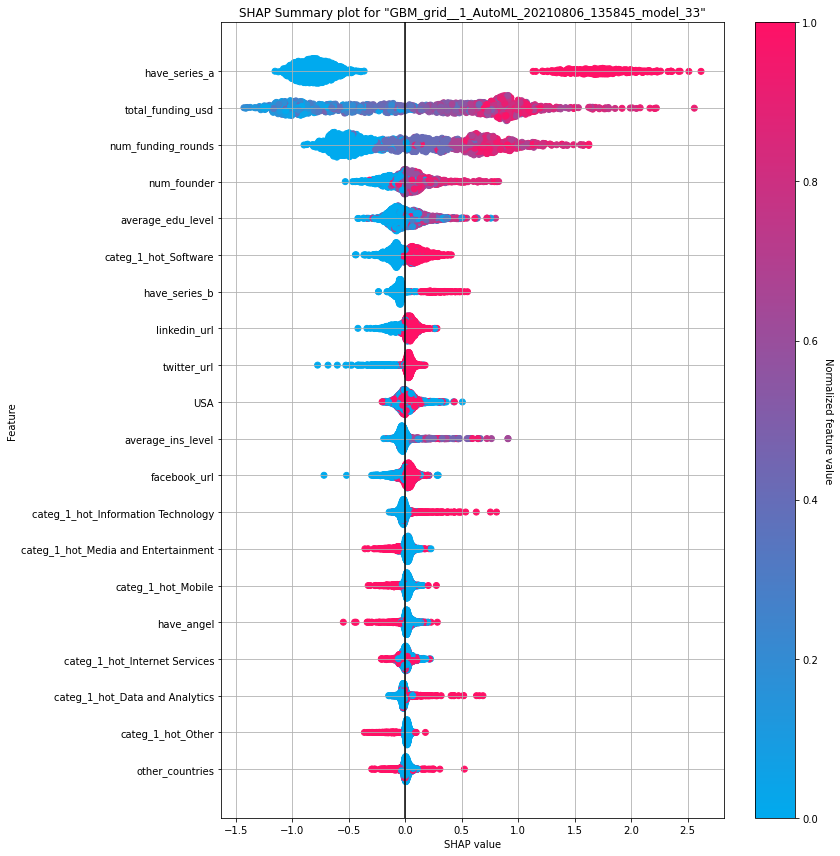

In [ ]:
summary = xgb.shap_summary_plot(X_test_hex)

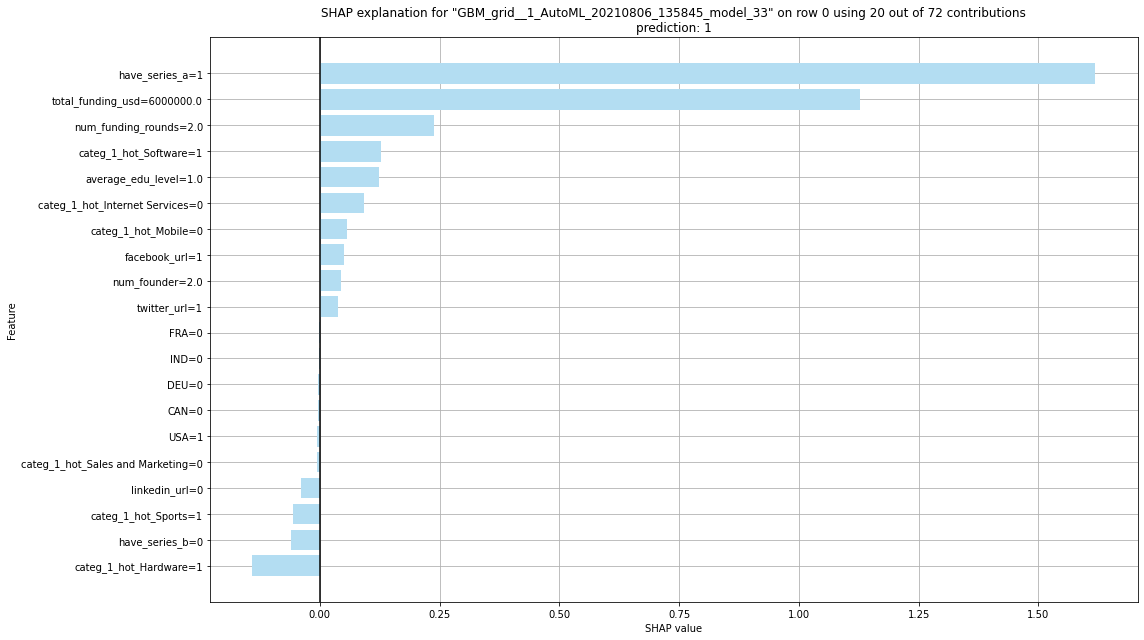

In [ ]:
varip_xgb = xgb.shap_explain_row_plot(X_test_hex,row_index=0)

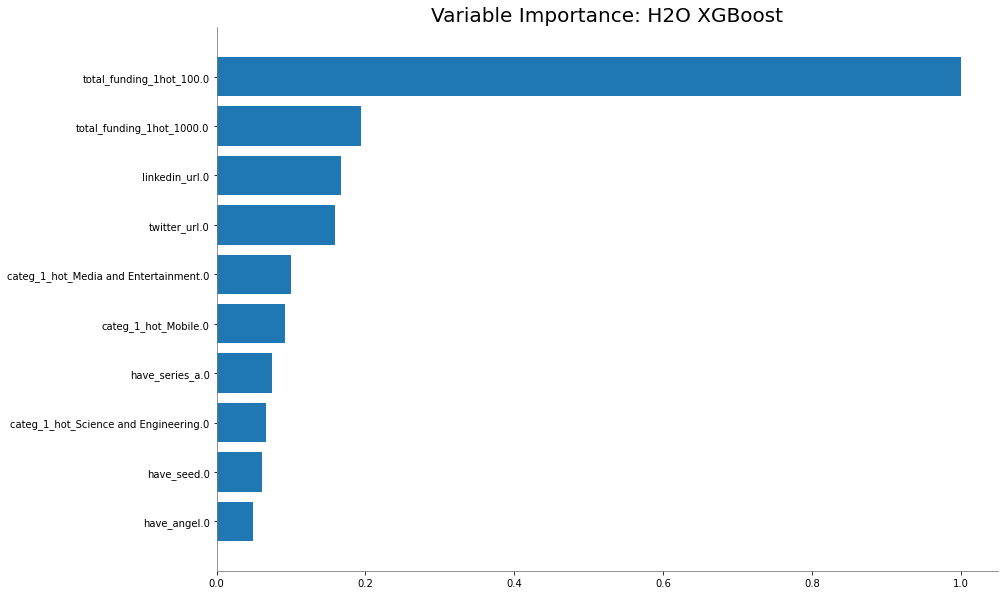

In [ ]:
varip_xgb = xgb.varimp_plot(10)

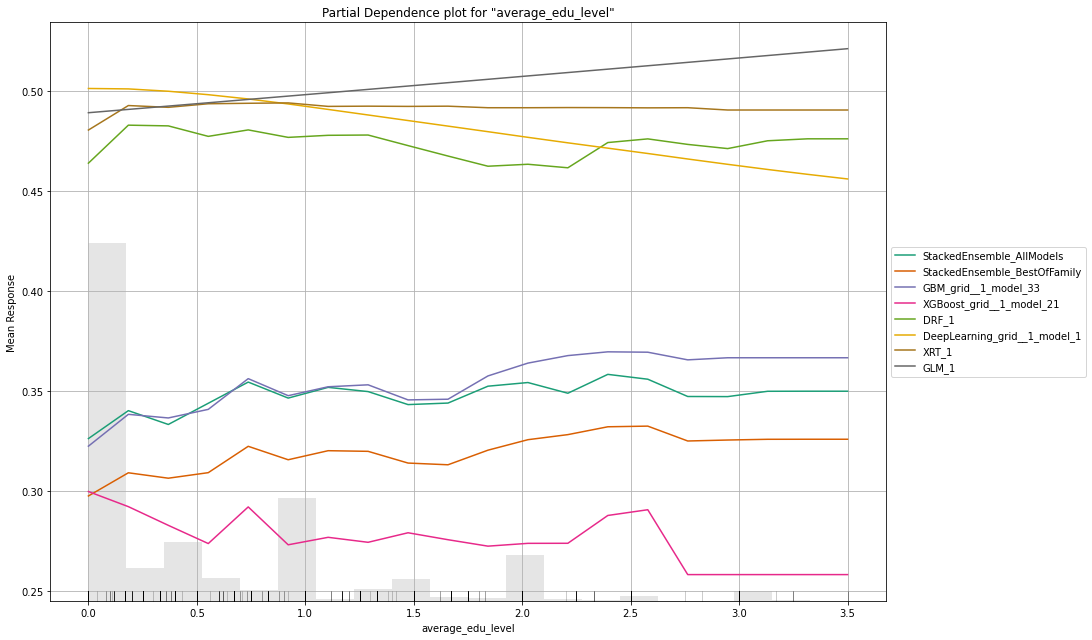

In [43]:
import numpy as np
# X_test_hex['total_funding_usd'] = h2o.H2OFrame(np.log(X_test_hex['total_funding_usd'].as_data_frame()))
pd_plot = aml.pd_multi_plot(X_test_hex,'average_edu_level')

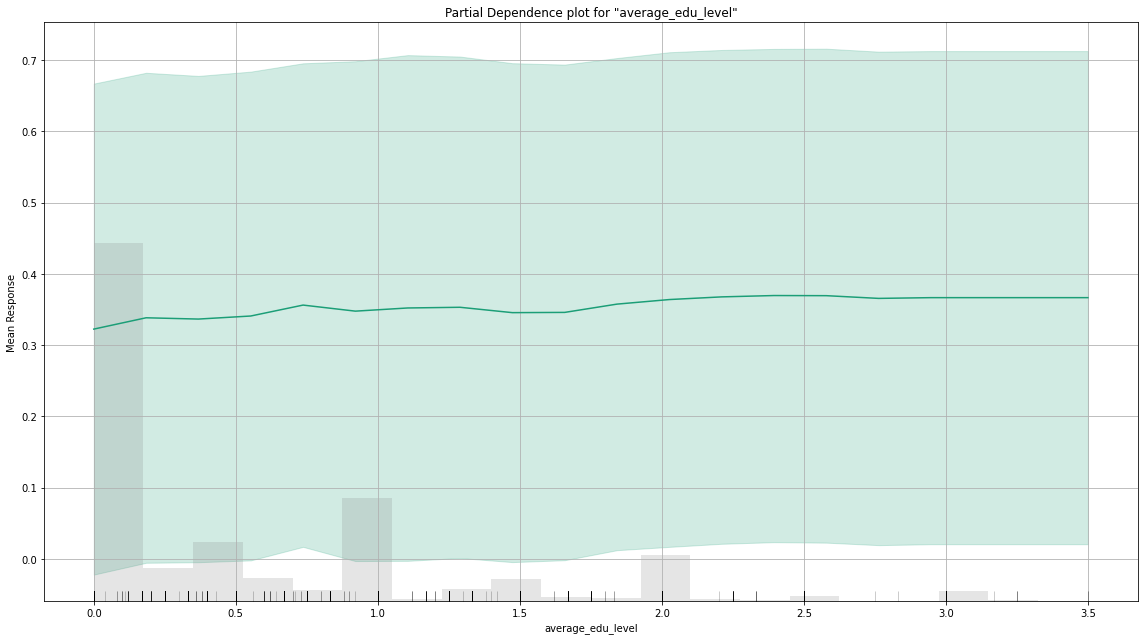

In [42]:
pd_plot = xgb.pd_plot(X_test_hex,'average_edu_level')